In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!pwd

/content


In [ ]:
!kaggle datasets download sahilwagh/gold-stock-prices

Dataset URL: https://www.kaggle.com/datasets/sahilwagh/gold-stock-prices
License(s): apache-2.0


In [ ]:
!unzip gold-stock-prices.zip

Archive:  gold-stock-prices.zip
  inflating: goldstock v1.csv        
  inflating: goldstock v2.csv        


In [ ]:
!rm -rf gold-stock-prices.zip

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import xgboost as xgb

import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
device

device(type='cpu')

In [ ]:
gs_v1 = pd.read_csv('goldstock v1.csv', index_col=0)
gs_v2 = pd.read_csv('goldstock v2.csv', index_col=0)

In [ ]:
gs_v1.head()

,Date,Close,Volume,Open,High,Low
0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1


In [ ]:
gs_v2.head()

,Date,Close/Last,Volume,Open,High,Low
0,2024-07-03,2369.4,185930.0,2338.6,2374.5,2335.7
1,2024-07-02,2333.4,146568.0,2341.6,2346.1,2327.4
2,2024-07-01,2338.9,136861.0,2336.2,2348.8,2328.2
3,2024-06-28,2339.6,131191.0,2338.6,2350.6,2329.7
4,2024-06-27,2336.6,135784.0,2309.4,2342.0,2306.8


In [ ]:
gs_v2 = gs_v2.rename(columns={"Close/Last": "Close"})

In [ ]:
original_ds = pd.concat([gs_v1, gs_v2], ignore_index=True)

In [ ]:
original_ds["Date"] = pd.to_datetime(original_ds["Date"])
original_ds.sort_values(by="Date", inplace=True)
original_ds.set_index('Date', inplace=True)

In [ ]:
original_ds.head()

,Close,Volume,Open,High,Low
Date,,,,,
2014-01-22,1238.6,80262.0,1240.5,1243.5,1235.5
2014-01-23,1262.5,41697.0,1235.1,1267.1,1230.8
2014-01-24,1264.5,34998.0,1264.3,1273.2,1256.9
2014-01-27,1263.5,63419.0,1269.9,1280.1,1252.0
2014-01-28,1250.5,81426.0,1254.9,1261.9,1248.0


In [ ]:
print(f"Shape: {original_ds.shape}")

Shape: (5022, 5)


In [ ]:
print("Missing values:")
print(original_ds.isnull().sum())

Missing values:
Close     0
Volume    0
Open      0
High      0
Low       0
dtype: int64


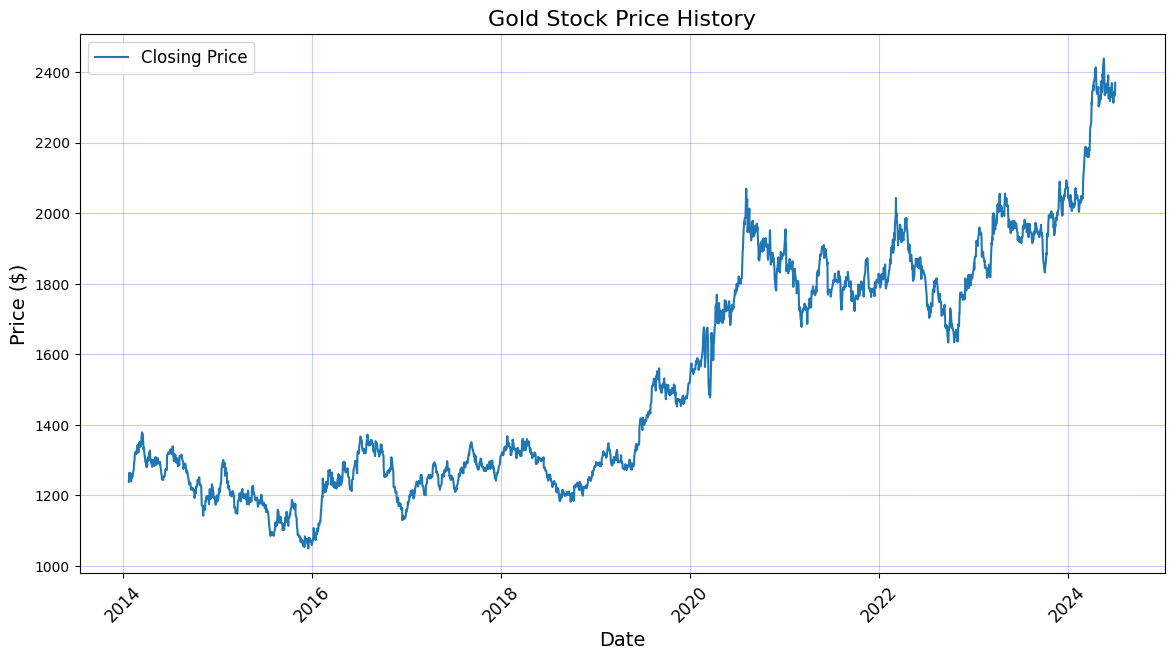

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(original_ds.index, original_ds['Close'], label='Closing Price')
plt.title('Gold Stock Price History', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.axis(True)
plt.xticks(fontsize=12, rotation=45)
plt.show()

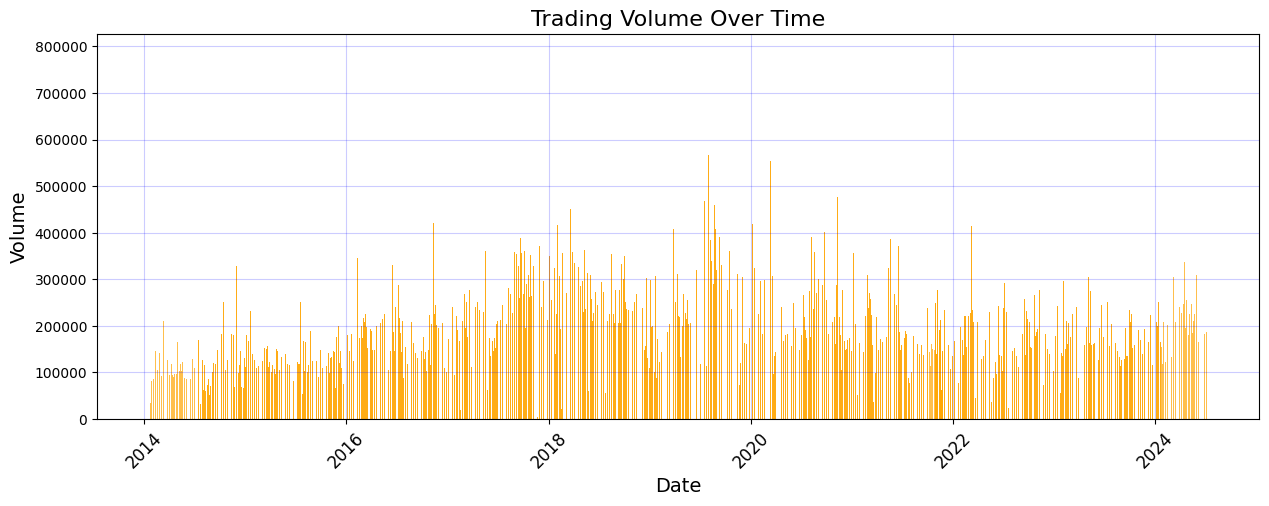

In [ ]:
plt.figure(figsize=(15, 5))
plt.bar(original_ds.index, original_ds['Volume'], color='orange', alpha=0.7)
plt.title('Trading Volume Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.axis(True)
plt.xticks(fontsize=12, rotation=45)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.2
plt.rcParams['grid.color'] = "blue"
plt.show()

In [ ]:
def outliers_removal(data):
  iso_forest = IsolationForest(contamination=0.01, random_state=42)
  detected_outliers = iso_forest.fit_predict(data[["Open", "High", "Low",  "Close", "Volume"]])
  return data[detected_outliers == 1]

In [ ]:
no_outliers_ds = outliers_removal(original_ds)

In [ ]:
print(f"Data shape after outlier removal: {no_outliers_ds.shape}")

Data shape after outlier removal: (4971, 5)


In [ ]:
def engineer_features(data):
    data = data.copy()
    data['Range'] = data['High'] - data['Low']
    data['Shift'] = data['Close'].pct_change()

    data['MA_5'] = data['Close'].rolling(window=5).mean()
    data['MA_10'] = data['Close'].rolling(window=10).mean()
    data['MA_20'] = data['Close'].rolling(window=20).mean()

    data['Momentum_5'] = data['Close'].diff(5)
    data['Momentum_10'] = data['Close'].diff(10)

    data['Volatility_5'] = data['Close'].rolling(window=5).std()
    data['Volatility_10'] = data['Close'].rolling(window=10).std()

    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    data = data.dropna()

    return data


In [ ]:
enriched_ds = engineer_features(no_outliers_ds)
print(f"Dataset after feature engineering: {enriched_ds.shape}")

Dataset after feature engineering: (4952, 15)


In [ ]:
def normalization(data):
    data = data.copy()

    features = [
        'Open', 'High', 'Low', 'Close', 'Volume', 'Range', 'MA_5',
        'MA_10', 'MA_20', 'Momentum_5', 'Momentum_10', 'Volatility_5',
        'Volatility_10', 'RSI'
    ]

    predict_scaler = MinMaxScaler(feature_range=(0, 1))
    feature_scaler = MinMaxScaler(feature_range=(0, 1))

    data['Close_scaled'] = predict_scaler.fit_transform(data[['Close']])

    data[features] = feature_scaler.fit_transform(data[features])

    return data, predict_scaler, feature_scaler


In [ ]:
normalized_ds, predict_scaler, feature_scaler = normalization(enriched_ds)
normalized_ds.head()

,Close,Volume,Open,High,Low,Range,Shift,MA_5,MA_10,MA_20,Momentum_5,Momentum_10,Volatility_5,Volatility_10,RSI,Close_scaled
Date,,,,,,,,,,,,,,,,
2014-02-19,0.209452,0.134898,0.208800,0.201019,0.207317,0.109133,-0.003020,0.199795,0.182128,0.168751,0.553609,0.695184,0.177548,0.326276,0.726636,0.209452
2014-02-20,0.206745,0.154181,0.209108,0.202796,0.205901,0.140867,-0.002651,0.203254,0.186879,0.171968,0.527770,0.670433,0.125238,0.305903,0.831551,0.206745
2014-02-21,0.211927,0.129734,0.209572,0.205498,0.212825,0.099845,0.005088,0.206965,0.192137,0.174478,0.532522,0.687651,0.041654,0.269787,0.860585,0.211927
2014-02-24,0.223064,0.155379,0.219606,0.213530,0.215028,0.158669,0.010879,0.210029,0.198084,0.177497,0.520345,0.711057,0.107123,0.239096,0.853394,0.223064
2014-02-25,0.226700,0.153438,0.219915,0.217082,0.224862,0.097523,0.003513,0.212920,0.203468,0.180751,0.517078,0.691956,0.152382,0.213712,0.929577,0.226700


In [ ]:
def model_data_for_LSTM(data, sequence_length, target_column="Close_scaled"):
    X, y = [], []

    features = [
        'Open', 'High', 'Low', 'Close_scaled', 'Volume', 'Range', 'MA_5',
        'MA_10', 'MA_20', 'Momentum_5', 'Momentum_10', 'Volatility_5',
        'Volatility_10', 'RSI'
    ]

    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length][features].values)
        y.append(data.iloc[i+sequence_length][target_column])

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    return torch.tensor(X), torch.tensor(y)

In [ ]:
def jitter(X, noise_factor=0.01):
    noise = np.random.normal(0, noise_factor, X.shape).astype(np.float32)
    return X + noise

In [ ]:
SEQLEN = 10
TEST_SIZE = 0.2

X, y = model_data_for_LSTM(normalized_ds, SEQLEN)

X = X.numpy() if isinstance(X, torch.Tensor) else X
y = y.numpy() if isinstance(y, torch.Tensor) else y

X_augmented = jitter(X)

X = torch.tensor(np.concatenate([X, X_augmented]).astype(np.float32))
y = torch.tensor(np.concatenate([y, y]).astype(np.float32) )

print(f"Final dataset shape: X = {X.shape}, y = {y.shape}")

Final dataset shape: X = torch.Size([9884, 10, 14]), y = torch.Size([9884])


In [ ]:
def train_test_split_time_series(X, y, test_size=0.2):
    split_idx = int(len(X) * (1 - test_size))

    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    return (X_train.float(), X_test.float(),
            y_train.float().unsqueeze(1), y_test.float().unsqueeze(1))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split_time_series(X, y, TEST_SIZE)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

Training set: torch.Size([7907, 10, 14]), torch.Size([7907, 1])
Testing set: torch.Size([1977, 10, 14]), torch.Size([1977, 1])


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, lstm_units=64, dense_units=32, dropout_rate=0.2):
        super(LSTMModel, self).__init__()

        self.lstm1 = nn.LSTM(input_size, lstm_units, batch_first=True)
        self.batch_norm1 = nn.BatchNorm1d(lstm_units)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.lstm2 = nn.LSTM(lstm_units, lstm_units // 2, batch_first=True)
        self.batch_norm2 = nn.BatchNorm1d(lstm_units // 2)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc1 = nn.Linear(lstm_units // 2, dense_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(dense_units, 1)

        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
            elif isinstance(layer, nn.LSTM):
                for name, param in layer.named_parameters():
                    if "weight" in name:
                        nn.init.xavier_uniform_(param)
                    elif "bias" in name:
                        nn.init.zeros_(param)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = x[:, -1, :]
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        x = x.unsqueeze(1)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [ ]:
lstm_model = LSTMModel(input_size=X_train.shape[2]).to(device)

In [ ]:
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = nn.SmoothL1Loss()

In [ ]:
batch_size = 32

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def r2_metric(y_true, y_pred):
    return r2_score(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())

In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, device="cuda"):
    train_losses = []
    test_losses = []
    r2_scores = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)

                test_loss += loss.item()
                all_preds.append(y_pred)
                all_targets.append(y_batch)

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
        r2 = r2_metric(all_targets, all_preds)
        r2_scores.append(r2)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}, R²: {r2:.4f}")

    return train_losses, test_losses, r2_scores

In [ ]:
num_epochs = 50
train_losses, test_losses, r2_scores = train_model(lstm_model, train_loader, test_loader, loss_fn, optimizer, num_epochs, device=device)

Epoch 1/50 - Train Loss: 0.101437, Test Loss: 0.008798, R²: -1.2947
Epoch 2/50 - Train Loss: 0.013131, Test Loss: 0.003184, R²: 0.1731
Epoch 3/50 - Train Loss: 0.007193, Test Loss: 0.001782, R²: 0.5521
Epoch 4/50 - Train Loss: 0.004929, Test Loss: 0.010647, R²: -1.7366
Epoch 5/50 - Train Loss: 0.004041, Test Loss: 0.013952, R²: -2.5940
Epoch 6/50 - Train Loss: 0.003377, Test Loss: 0.003121, R²: 0.2188
Epoch 7/50 - Train Loss: 0.003027, Test Loss: 0.002479, R²: 0.3813
Epoch 8/50 - Train Loss: 0.002513, Test Loss: 0.002794, R²: 0.3030
Epoch 9/50 - Train Loss: 0.002389, Test Loss: 0.000860, R²: 0.7876
Epoch 10/50 - Train Loss: 0.002097, Test Loss: 0.001103, R²: 0.7267
Epoch 11/50 - Train Loss: 0.001864, Test Loss: 0.001418, R²: 0.6473
Epoch 12/50 - Train Loss: 0.001661, Test Loss: 0.001517, R²: 0.6250
Epoch 13/50 - Train Loss: 0.001433, Test Loss: 0.006436, R²: -0.6490
Epoch 14/50 - Train Loss: 0.001577, Test Loss: 0.006950, R²: -0.7770
Epoch 15/50 - Train Loss: 0.001403, Test Loss: 0.000

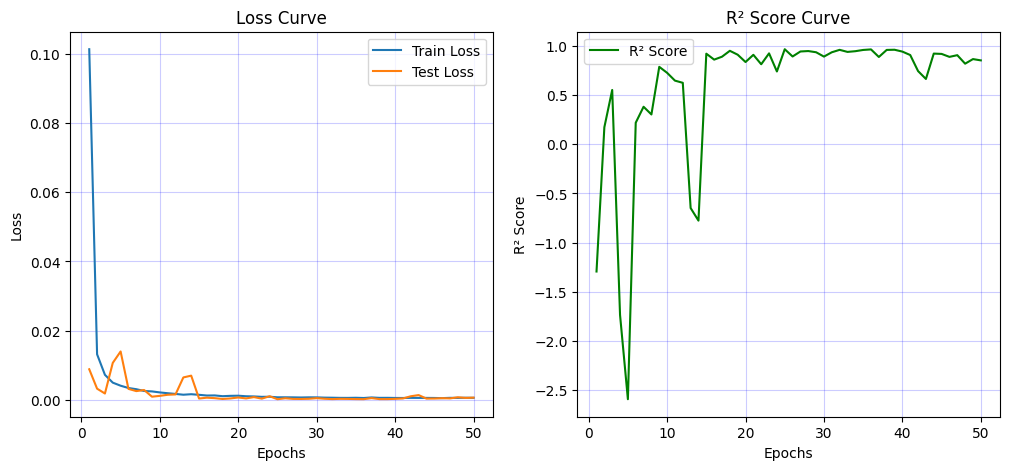

In [ ]:
epochs = range(1, 51)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot R²
plt.subplot(1, 2, 2)
plt.plot(epochs, r2_scores, label="R² Score", color='green')
plt.xlabel("Epochs")
plt.ylabel("R² Score")
plt.title("R² Score Curve")
plt.legend()

plt.show()

In [ ]:
def predict(model, loader):
  lstm_predictions = []
  y_true = []

  model.eval()

  with torch.no_grad():
      for X_batch, y_batch in loader:
          X_batch = X_batch.to(device)
          y_batch = y_batch.to(device)

          y_pred = model(X_batch)
          lstm_predictions.append(y_pred.cpu())
          y_true.append(y_batch.cpu())

  lstm_predictions = torch.cat(lstm_predictions, dim=0)
  y_test = torch.cat(y_true, dim=0)

  return y_test, lstm_predictions

In [ ]:
y_test, lstm_predictions = predict(lstm_model, test_loader)

In [ ]:
def plot_lstm_predictions(y_true, lstm_pred, n_samples=100):
    plt.figure(figsize=(15, 8))

    idx = torch.randperm(len(y_true))[:min(n_samples, len(y_true))]

    plt.plot(y_true[idx].cpu().numpy(), label='Actual', color='blue', alpha=0.7)
    plt.plot(lstm_pred[idx].cpu().numpy(), label='LSTM Predicted', color='green', linestyle='--', alpha=0.7)

    plt.title('Actual vs Predicted Stock Prices', fontsize=16)
    plt.xlabel('Sample Index', fontsize=14)
    plt.ylabel('Normalized Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

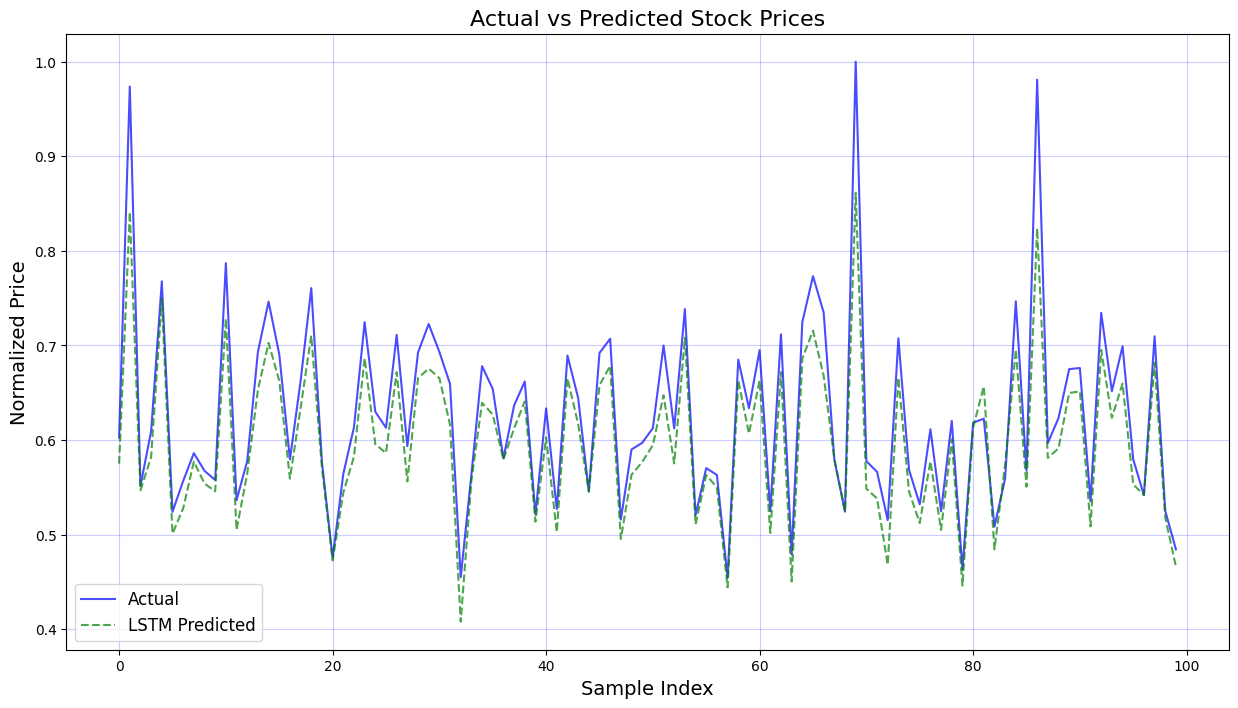

In [ ]:
plot_lstm_predictions(y_test, lstm_predictions)

In [ ]:
def inverse_transform_predictions(preds, scaler):
    # Reshape predictions for inverse transformation
    preds_2d = np.array(preds).reshape(-1, 1)

    # Inverse transform using the correct scaler
    original_scale = scaler.inverse_transform(preds_2d).flatten()

    return original_scale

In [ ]:
target_prices = inverse_transform_predictions(y_test, predict_scaler)
lstm_prices = inverse_transform_predictions(lstm_predictions, predict_scaler)

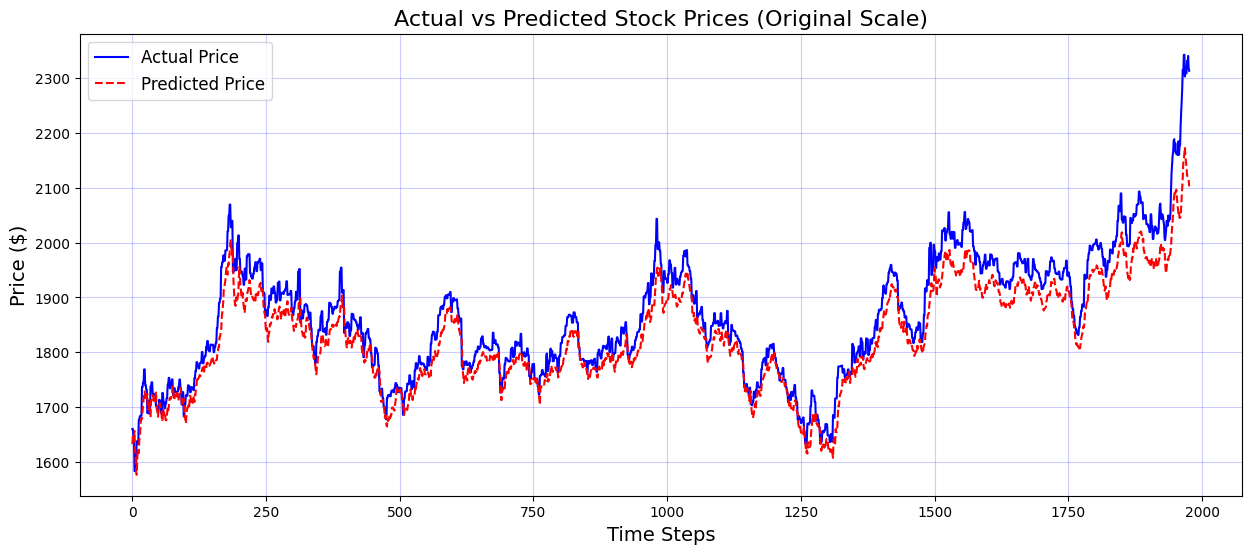

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(target_prices, label='Actual Price', color='blue')
plt.plot(lstm_prices, label='Predicted Price', color='red', linestyle='--')
plt.title('Actual vs Predicted Stock Prices (Original Scale)', fontsize=16)
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
def engineer__prediction_features(data):
    data = data.copy()

    # Feature Engineering
    data['Range'] = data['High'] - data['Low']
    data['Shift'] = data['Close'].pct_change()

    data['MA_5'] = data['Close'].rolling(window=5).mean()
    data['MA_10'] = data['Close'].rolling(window=10).mean()
    data['MA_20'] = data['Close'].rolling(window=20).mean()

    data['Momentum_5'] = data['Close'].diff(5)
    data['Momentum_10'] = data['Close'].diff(10)

    data['Volatility_5'] = data['Close'].rolling(window=5).std()
    data['Volatility_10'] = data['Close'].rolling(window=10).std()

    # RSI Calculation
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # Handling NaNs
    data = data.ffill()
    data = data.bfill()
    data = data.fillna(0)

    return data

In [ ]:
predict_ds = engineer__prediction_features(original_ds)

In [ ]:
predict_ds, close_scaler, _ = normalization(predict_ds)

In [ ]:
def model_data_for_prediction(data, sequence_length):
    X, y = [], []

    features = [
        'Open', 'High', 'Low', 'Close_scaled', 'Volume', 'Range', 'MA_5',
        'MA_10', 'MA_20', 'Momentum_5', 'Momentum_10', 'Volatility_5',
        'Volatility_10', 'RSI'
    ]

    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length][features].values)

    X = np.array(X, dtype=np.float32)

    return torch.tensor(X)

In [ ]:
X_prediction = model_data_for_prediction(predict_ds, SEQLEN)

In [ ]:
def final_predict(model, x_prediction):
    model.eval()

    x_tensor = x_prediction.to(device)

    if len(x_tensor.shape) == 2:
        x_tensor = x_tensor.unsqueeze(0)

    with torch.no_grad():
        y_pred = model(x_tensor)

    return y_pred.cpu().numpy().flatten()

In [ ]:
y_predicted = final_predict(lstm_model, X_prediction)

In [ ]:
descaled_prediction = inverse_transform_predictions(y_predicted, close_scaler)

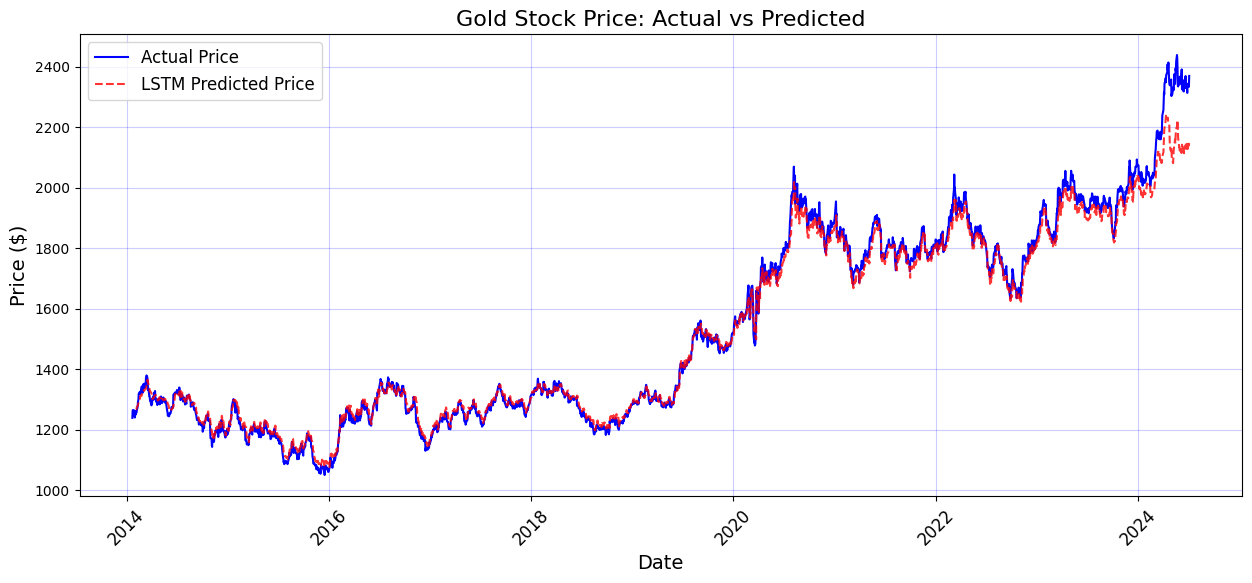

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(original_ds.index, original_ds['Close'], label='Actual Price', color='blue')

plt.plot(original_ds.index[SEQLEN:], descaled_prediction, label='LSTM Predicted Price', color='red', linestyle='--', alpha=0.8)

plt.title('Gold Stock Price: Actual vs Predicted', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12, rotation=45)

plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Ensure lstm_prices aligns with actual values
start_idx = len(original_ds) - len(descaled_prediction)
actual_prices = original_ds['Close'].iloc[start_idx:]

# Compute evaluation metrics
mae = mean_absolute_error(actual_prices, descaled_prediction)
mse = mean_squared_error(actual_prices, descaled_prediction)
rmse = np.sqrt(mse)
r2 = r2_score(actual_prices, descaled_prediction)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 20.5491
Mean Squared Error (MSE): 1074.2195
Root Mean Squared Error (RMSE): 32.7753
R² Score: 0.9893


In [ ]:
def build_xgboost_model(n_estimators=100, max_depth=5, learning_rate=0.1):

    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=42
    )
    return model

In [ ]:
xgb_X_train = X_train.reshape(X_train.shape[0], -1)
xgb_X_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
xgb_model = build_xgboost_model()

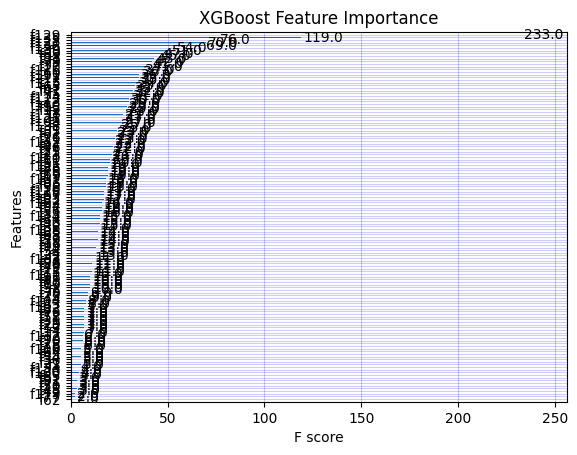

In [ ]:
# Train XGBoost Model
xgb_model.fit(xgb_X_train, y_train)

# Feature importance
xgb.plot_importance(xgb_model)
plt.title('XGBoost Feature Importance')
plt.show()

In [ ]:
# Make predictions
y_test, lstm_pred = predict(lstm_model, test_loader)
lstm_pred = lstm_pred.flatten()
lstm_pred = lstm_pred.cpu().numpy()

xgb_pred = xgb_model.predict(xgb_X_test)

# Hybrid prediction (weighted ensemble)
hybrid_pred = 0.6 * lstm_pred + 0.4 * xgb_pred

In [ ]:
def evaluate_models(y_true, lstm_pred, xgb_pred, hybrid_pred):

    results = []

    def calculate_metrics(y_true, y_pred, model_name):
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        return {
            "Model": model_name,
            "MSE": round(mse, 6),
            "MAE": round(mae, 6),
            "R² Score": round(r2, 4)
        }

    results.append(calculate_metrics(y_true, lstm_pred, "LSTM"))
    results.append(calculate_metrics(y_true, xgb_pred, "XGBoost"))
    results.append(calculate_metrics(y_true, hybrid_pred, "Hybrid"))

    return pd.DataFrame(results)



In [ ]:
results_df = evaluate_models(y_test, lstm_pred, xgb_pred, hybrid_pred)
print("Model Performance Comparison:")
display(results_df)

Model Performance Comparison:


,Model,MSE,MAE,R² Score
0,LSTM,0.001124,0.027590,0.8532
1,XGBoost,0.000160,0.009388,0.9791
2,Hybrid,0.000482,0.017682,0.9370


In [ ]:
def plot_predictions(y_true, lstm_pred, xgb_pred, hybrid_pred, n_samples=100):
    plt.figure(figsize=(15, 8))

    # Select a subset for clearer visualization
    idx = np.random.choice(len(y_true), size=min(n_samples, len(y_true)), replace=False)

    plt.plot(y_true[idx], label='Actual', color='blue', alpha=0.7)
    plt.plot(lstm_pred[idx], label='LSTM', color='green', linestyle='--', alpha=0.7)
    plt.plot(xgb_pred[idx], label='XGBoost', color='red', linestyle='--', alpha=0.7)
    plt.plot(hybrid_pred[idx], label='Hybrid', color='purple', linestyle='-', alpha=0.9)

    plt.title('Actual vs Predicted Stock Prices', fontsize=16)
    plt.xlabel('Sample Index', fontsize=14)
    plt.ylabel('Normalized Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()


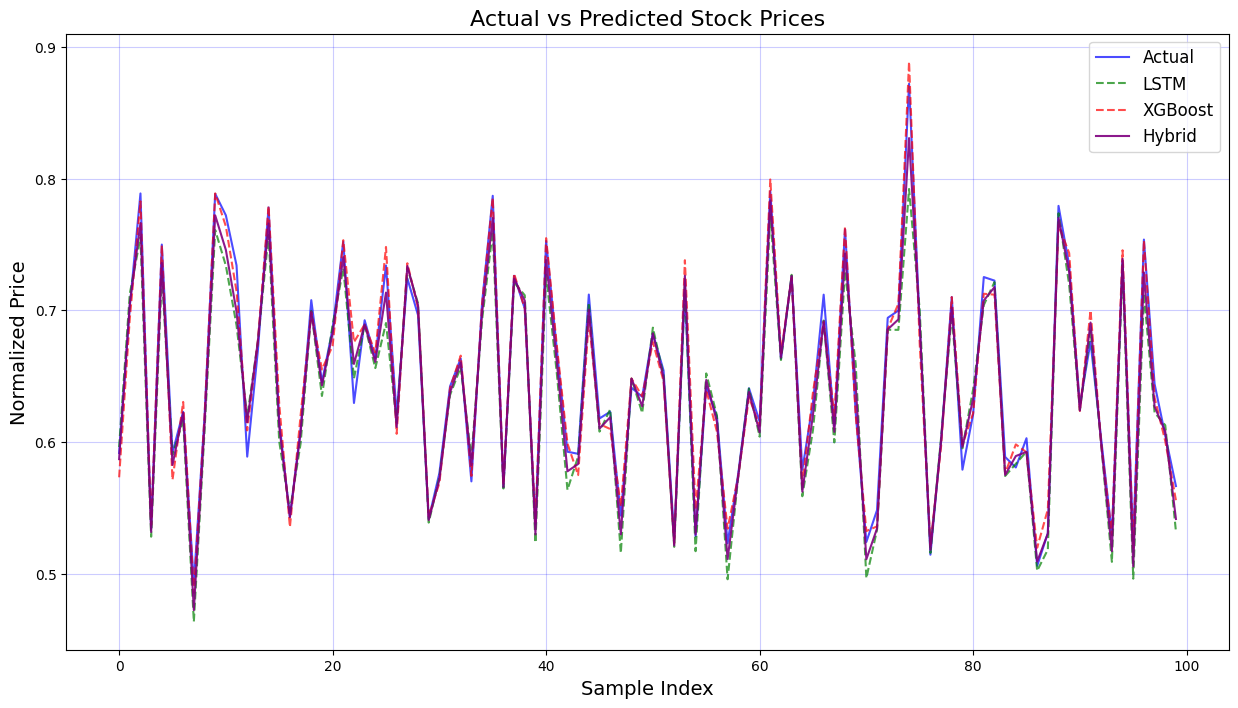

In [ ]:
plot_predictions(y_test, lstm_pred, xgb_pred, hybrid_pred)

In [ ]:
actual_prices = inverse_transform_predictions(y_test, predict_scaler)
hybrid_prices = inverse_transform_predictions(hybrid_pred, predict_scaler)

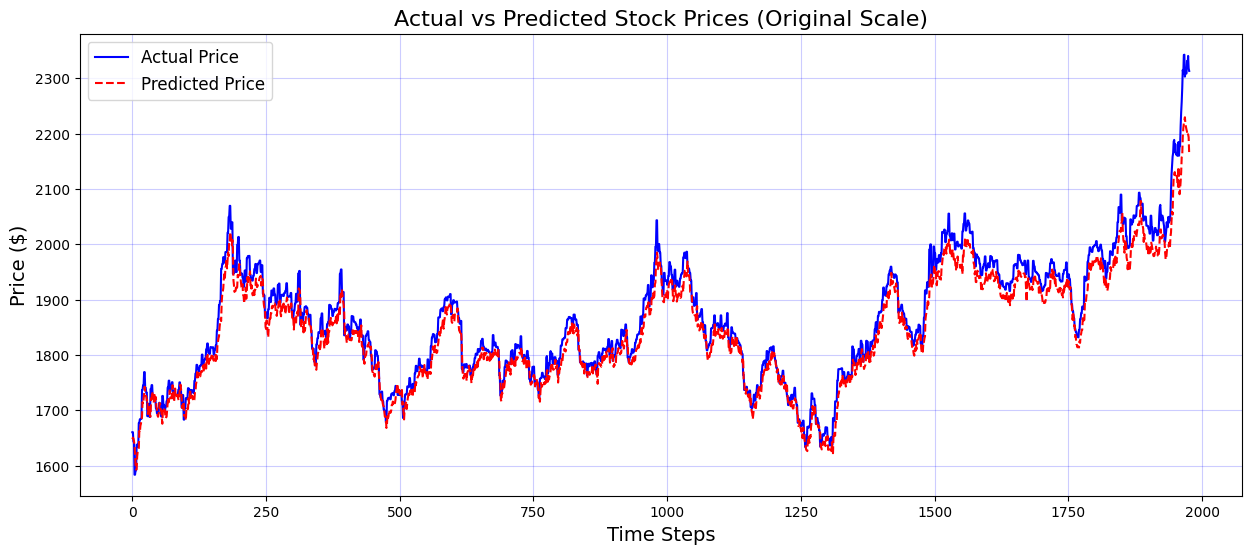

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(actual_prices, label='Actual Price', color='blue')
plt.plot(hybrid_prices, label='Predicted Price', color='red', linestyle='--')
plt.title('Actual vs Predicted Stock Prices (Original Scale)', fontsize=16)
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
### FINAL PREDICTIONS

In [ ]:
target = original_ds['Close']

In [ ]:
xgb_x = xgb_X_test = X_prediction.reshape(X_prediction.shape[0], -1)

In [ ]:
xgb_final = xgb_model.predict(xgb_X_test)

In [ ]:
hybrid_final = 0.6 * y_predicted + 0.4 * xgb_final

In [ ]:
hybrid_prices = inverse_transform_predictions(hybrid_final, close_scaler)

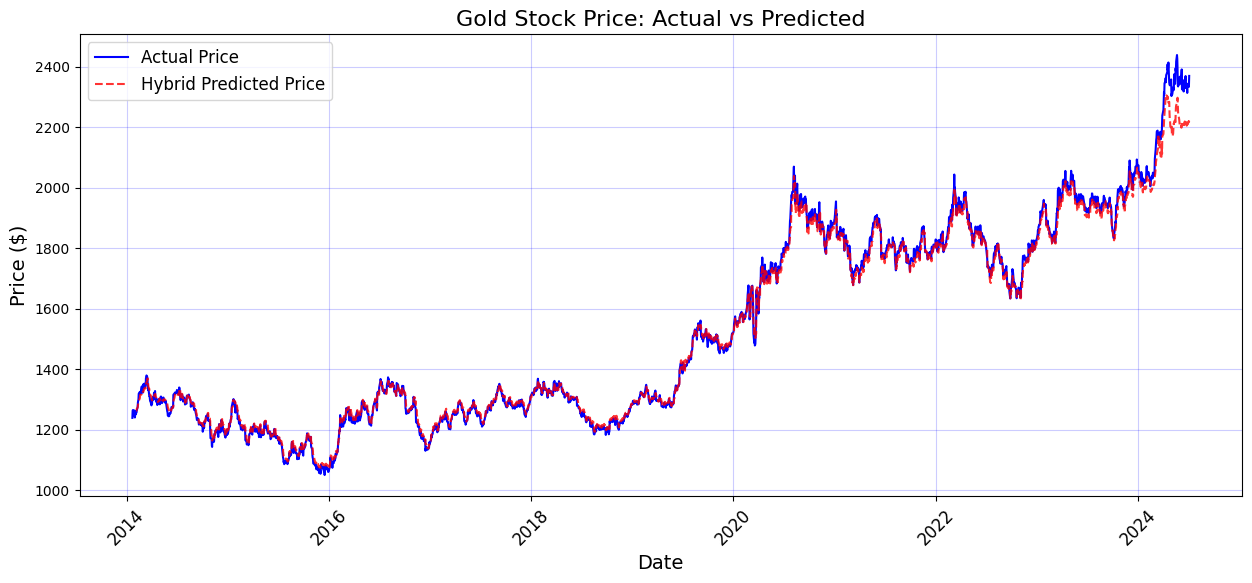

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(original_ds.index, target, label='Actual Price', color='blue')

plt.plot(original_ds.index[SEQLEN:], hybrid_prices, label='Hybrid Predicted Price', color='red', linestyle='--', alpha=0.8)

plt.title('Gold Stock Price: Actual vs Predicted', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12, rotation=45)

plt.show()

In [ ]:
# Save models
torch.save(lstm_model.state_dict(), "lstm_model.pth")
print("LSTM model saved successfully!")

LSTM model saved successfully!


In [ ]:
import joblib

# Save XGBoost model
joblib.dump(xgb_model, "xgb_model.pkl")
print("XGBoost model saved successfully!")

XGBoost model saved successfully!


In [ ]:
joblib.dump(feature_scaler, "feature_scaler.pkl")
joblib.dump(close_scaler, "close_scaler.pkl")

['close_scaler.pkl']